In [1]:
import sys
sys.executable

'/home/sslab/anaconda3/bin/python'

In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import warnings
from tqdm import tqdm

warnings.filterwarnings(action='ignore')

weight_dir = '/media/sslab/1390f618-020d-402b-871b-0238fac8293c/Atomy/hoonseo/ncf_weight/'

In [3]:
ratings_df = pd.read_csv('ratings.csv')
ratings_df.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [4]:
num_user = ratings_df['userId'].nunique()
num_item = ratings_df['movieId'].nunique()

sparsity = 1 - len(ratings_df) / (num_user * num_item)

print(f'전체 User 수: {num_user}')
print(f'전체 Item 수: {num_item}')
print(f'행렬의 희소성: {sparsity:.4f}')

전체 User 수: 610
전체 Item 수: 9724
행렬의 희소성: 0.9830


Text(0.5, 1.0, 'Rating distribution')

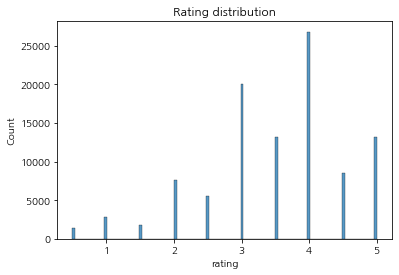

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(ratings_df['rating'])
plt.title('Rating distribution')

### Dataset

In [6]:
user_encoder, user_decoder = {}, {}
for idx, user_id in enumerate(ratings_df['userId'].unique()):
    user_encoder[user_id] = idx
    user_decoder[idx] = user_id

item_encoder, item_decoder = {}, {}
for idx, item_id in enumerate(ratings_df['movieId'].unique()):
    item_encoder[item_id] = idx
    item_decoder[idx] = item_id

In [7]:
ratings_df['en_userId'] = ratings_df['userId'].apply(lambda x : user_encoder[x])
ratings_df['en_movieId'] = ratings_df['movieId'].apply(lambda x : item_encoder[x])

In [25]:
def split_data(df, num_neg = 3):
    # positive 1개당 negative sampling 3개
    total_item_li = set([i for i in range(num_item)])
    train_df = []
    test_df = []
    en_user_id_li = df['en_userId'].unique()
    for en_user_id in tqdm(en_user_id_li):
        pos_recomencder_li = df[df['en_userId'] == en_user_id]['en_movieId'].tolist()
        neg_recomencder_li = np.random.choice(list(total_item_li - set(pos_recomencder_li)), num_neg * len(pos_recomencder_li), replace = False).tolist()
        train_df += [[en_user_id, en_movieId, 1] for en_movieId in pos_recomencder_li[:-1]] + [[en_user_id, en_movieId, 0] for en_movieId in neg_recomencder_li]

        neg_recomencder_li = np.random.choice(list(total_item_li - set(pos_recomencder_li)), 99, replace = False).tolist()
        test_df += [[en_user_id, pos_recomencder_li[-1], 1]] + [[en_user_id, en_movieId, 0] for en_movieId in neg_recomencder_li]
    
    return train_df, test_df

In [9]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        user = self.df[idx][0]
        item = self.df[idx][1]
        label = self.df[idx][2]

        return user, item, label

### GMF(Generalized Matrix Factorization)

In [10]:
class GMF(nn.Module):
    def __init__(self, num_user, num_item, num_factor):
        super(GMF, self).__init__()
        self.user_emb = nn.Embedding(num_user, num_factor)
        self.item_emb = nn.Embedding(num_item, num_factor)
        
        self.predict_layer = nn.Sequential(
            nn.Linear(num_factor, 1, bias = False),
            nn.Sigmoid()
        )

        self._init_weight_()
    
    def _init_weight_(self):
        nn.init.normal_(self.user_emb.weight, std=0.01)
        nn.init.normal_(self.item_emb.weight, std=0.01)
        for m in self.predict_layer:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=1, nonlinearity="sigmoid")
                # kaiming 초기화 : 정규 분포를 사용해 가중치를 초기화
    
    def forward(self, user, item):
        user_emb = self.user_emb(user)
        item_emb = self.item_emb(item)

        output = self.predict_layer(user_emb * item_emb) # element-wise product

        return output.view(-1)

### MLP(Multi Layer Perceptron)

In [11]:
class MLP(nn.Module):
    def __init__(self, num_user, num_item, num_factor, num_layers, dropout):
        super(MLP, self).__init__()
        self.dropout = dropout
        self.user_emb = nn.Embedding(num_user, num_factor)
        self.item_emb = nn.Embedding(num_item, num_factor)

        MLP_modules = []
        input_size = num_factor * 2
        for _ in range(num_layers):
            MLP_modules.append(nn.Dropout(p = self.dropout))
            MLP_modules.append(nn.Linear(input_size, input_size // 2))
            MLP_modules.append(nn.ReLU())
            input_size = input_size // 2
        self.MLP_layers = nn.Sequential(*MLP_modules)

        self.predict_layer = nn.Sequential(
            nn.Linear(input_size, 1, bias = False),
            nn.Sigmoid()
        )

        self._init_weight_()
    
    def _init_weight_(self):
        nn.init.normal_(self.user_emb.weight, std=0.01)
        nn.init.normal_(self.item_emb.weight, std=0.01)
        for m in self.MLP_layers:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                # xavier 초기화 : hidden layer의 노드 수에 따라 다른 표준 편차를 할당하여 가중치 초기화
        
        for m in self.predict_layer:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=1, nonlinearity="sigmoid")
    
    def forward(self, user, item):
        user_emb = self.user_emb(user)
        item_emb = self.item_emb(item)
        
        cat_emb = torch.cat((user_emb, item_emb), -1) # concat

        output = self.MLP_layers(cat_emb)

        output = self.predict_layer(output)

        return output.view(-1)

### NeuMF

In [12]:
class NeuMF(nn.Module):
    def __init__(self, GMF, MLP, num_factor):
        super(NeuMF, self).__init__()
        # GMF와 MLP 서로 다른 embedding layer
        self.gmf_user_emb = GMF.user_emb
        self.gmf_item_emb = GMF.item_emb

        self.mlp_user_emb = MLP.user_emb
        self.mlp_item_emb = MLP.item_emb

        self.mlp_layer = MLP.MLP_layers # 마지막 predict layer

        self.predict_layer = nn.Sequential(
            nn.Linear(num_factor + (num_factor // 2), 1, bias = False),
            nn.Sigmoid(),
        )
        self._init_weight_()
    
    def _init_weight_(self):
        for m in self.predict_layer:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=1, nonlinearity="sigmoid")

    def forward(self, user, item):
        gmf_user_emb = self.gmf_user_emb(user)
        gmf_item_emb = self.gmf_item_emb(item)
        gmf_output = gmf_user_emb * gmf_item_emb # element-wise product

        mlp_user_emb = self.mlp_user_emb(user)
        mlp_item_emb = self.mlp_item_emb(item)
        mlp_cat_emb = torch.cat((mlp_user_emb, mlp_item_emb), -1) # concat
        mlp_output = self.mlp_layer(mlp_cat_emb)
        
        cat_output = torch.cat((gmf_output, mlp_output), -1) # concat

        output = self.predict_layer(cat_output)

        return output.view(-1)

### train 설정

In [13]:
def hit(target_item, pred_items):
    if target_item in pred_items:
        return 1
    return 0

def ndcg(target_item, pred_items):
    if target_item in pred_items:
        idx = pred_items.index(target_item)
        # 초기 인덱스가 0이기 때문에 +2 함
        return np.reciprocal(np.log2(idx + 2))
    return 0

def metrics(model, test_loader, top_k):
    model.eval()
    HR, NDCG = [], []
    with torch.no_grad():
        for user, item, _ in test_loader:
            user = user.to(device)
            item = item.to(device)

            predictions = model(user, item)
            # 가장 높은 top_k개 선택
            _, indices = torch.topk(predictions, top_k)
            # 해당 상품 index 선택
            recommends = torch.take(item, indices).cpu().numpy().tolist()
            # 정답값 선택
            target_item = item[0].item()
            HR.append(hit(target_item, recommends))
            NDCG.append(ndcg(target_item, recommends))

    return np.mean(HR), np.mean(NDCG)
    
def train(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0

    for user, item, label in train_loader:
        user = user.to(device)
        item = item.to(device)
        label = label.to(device)
        label = label.float()

        optimizer.zero_grad()
        output = model(user, item)
        loss = criterion(output, label)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    train_loss = train_loss / len(train_loader)

    return train_loss

In [30]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
batch_size = 256
epochs = 30
lr = 0.005
num_factor = 64
num_layers = 2
dropout = 0.2
top_k = 30
num_neg = 2

In [31]:
train_df, test_df = split_data(df = ratings_df, num_neg = num_neg)

100%|██████████| 610/610 [00:01<00:00, 364.29it/s]


In [33]:
len(train_df), len(test_df)

(301898, 61000)

In [34]:
train_dataset = CustomDataset(df = train_df)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = False)

test_dataset = CustomDataset(df = test_df)
test_loader = DataLoader(test_dataset, batch_size = 100, shuffle = False, drop_last = False)

### GMF + MLP pre-train

In [36]:
gmf = GMF(num_user = num_user, num_item = num_item, num_factor = num_factor).to(device)
gmf_optimizer = torch.optim.Adam(gmf.parameters(), lr = lr)

mlp = MLP(num_user = num_user, num_item = num_item, num_factor = num_factor, num_layers = num_layers, dropout = dropout).to(device)
mlp_optimizer = torch.optim.Adam(mlp.parameters(), lr = lr)

loss_fc = nn.BCELoss() # Binary Cross Entropy Loss

In [37]:
gmf_best_metric = 0
mlp_best_metric = 0

for epoch in range(1, epochs + 1):
    gmf_train_loss = train(model = gmf, train_loader = train_loader, criterion = loss_fc, optimizer = gmf_optimizer)
    gmf_hr, gmf_ndcg = metrics(model = gmf, test_loader = test_loader, top_k = top_k)

    mlp_train_loss = train(model = mlp, train_loader = train_loader, criterion = loss_fc, optimizer = mlp_optimizer)
    mlp_hr, mlp_ndcg  = metrics(model = mlp, test_loader = test_loader, top_k = top_k)

    print(f"[EPOCH: {epoch}], GMF Train Loss: {gmf_train_loss:.4f}, MLP Train Loss: {mlp_train_loss:.4f}, GMF HR: {gmf_hr:.4f}, MLP HR: {mlp_hr:.4f}, GMF NDCG: {gmf_ndcg:.4f}, MLP NDCG: {mlp_ndcg:.4f}")

    if gmf_best_metric < gmf_ndcg:
        gmf_best_metric = gmf_ndcg
        torch.save(gmf.state_dict(), weight_dir + f'GMF.pt')

    if mlp_best_metric < mlp_ndcg:
        mlp_best_metric = mlp_ndcg
        torch.save(mlp.state_dict(), weight_dir + f'MLP.pt')

[EPOCH: 1], GMF Train Loss: 0.4661, MLP Train Loss: 0.4408, GMF HR: 0.7590, MLP HR: 0.7262, GMF NDCG: 0.3468, MLP NDCG: 0.3355
[EPOCH: 2], GMF Train Loss: 0.2598, MLP Train Loss: 0.3997, GMF HR: 0.7738, MLP HR: 0.7328, GMF NDCG: 0.3444, MLP NDCG: 0.3346
[EPOCH: 3], GMF Train Loss: 0.0774, MLP Train Loss: 0.3873, GMF HR: 0.7525, MLP HR: 0.7361, GMF NDCG: 0.3328, MLP NDCG: 0.3400
[EPOCH: 4], GMF Train Loss: 0.0190, MLP Train Loss: 0.3691, GMF HR: 0.7525, MLP HR: 0.7410, GMF NDCG: 0.3393, MLP NDCG: 0.3453
[EPOCH: 5], GMF Train Loss: 0.0046, MLP Train Loss: 0.3434, GMF HR: 0.7557, MLP HR: 0.7492, GMF NDCG: 0.3438, MLP NDCG: 0.3642
[EPOCH: 6], GMF Train Loss: 0.0012, MLP Train Loss: 0.3180, GMF HR: 0.7623, MLP HR: 0.7426, GMF NDCG: 0.3467, MLP NDCG: 0.3511
[EPOCH: 7], GMF Train Loss: 0.0003, MLP Train Loss: 0.2996, GMF HR: 0.7557, MLP HR: 0.7574, GMF NDCG: 0.3496, MLP NDCG: 0.3541
[EPOCH: 8], GMF Train Loss: 0.0001, MLP Train Loss: 0.2870, GMF HR: 0.7574, MLP HR: 0.7475, GMF NDCG: 0.3495, M

### NeuMF train

In [38]:
# NeuMF 의 경우 pre-trained 모델을 사용한다고 함
# 그리고 optimizer로 SGD를 사용한다고 함
# 실제로 Adam 보다 더 좋은 성능을 보임

gmf = GMF(num_user = num_user, num_item = num_item, num_factor = num_factor).to(device)
gmf.load_state_dict(torch.load(weight_dir + f'GMF.pt'))

mlp = MLP(num_user = num_user, num_item = num_item, num_factor = num_factor, num_layers = num_layers, dropout = dropout).to(device)
mlp.load_state_dict(torch.load(weight_dir + f'MLP.pt'))

nmf = NeuMF(GMF = gmf, MLP = mlp, num_factor = num_factor).to(device)
nmf_optimizer = torch.optim.SGD(nmf.parameters(), lr = lr, momentum = 0.9) # SGD 사용

In [39]:
nmf_best_metric = 0

for epoch in range(1, epochs + 1):
    nmf_train_loss = train(model = nmf, train_loader = train_loader, criterion = loss_fc, optimizer = nmf_optimizer)
    nmf_hr, nmf_ndcg = metrics(model = nmf, test_loader = test_loader, top_k = top_k)

    print(f"[EPOCH: {epoch}], NeuMF Train Loss: {nmf_train_loss:.4f}, NeuMF HR: {nmf_hr:.4f}, NeuMF NDCG: {nmf_ndcg:.4f}")

    if nmf_best_metric < nmf_ndcg:
        nmf_best_metric = nmf_ndcg
        torch.save(nmf.state_dict(), weight_dir + f'NeuMF.pt')

[EPOCH: 1], NeuMF Train Loss: 0.1268, NeuMF HR: 0.7639, NeuMF NDCG: 0.3875
[EPOCH: 2], NeuMF Train Loss: 0.0594, NeuMF HR: 0.7770, NeuMF NDCG: 0.3848
[EPOCH: 3], NeuMF Train Loss: 0.0381, NeuMF HR: 0.7738, NeuMF NDCG: 0.3828
[EPOCH: 4], NeuMF Train Loss: 0.0278, NeuMF HR: 0.7787, NeuMF NDCG: 0.3811
[EPOCH: 5], NeuMF Train Loss: 0.0218, NeuMF HR: 0.7705, NeuMF NDCG: 0.3757
[EPOCH: 6], NeuMF Train Loss: 0.0178, NeuMF HR: 0.7738, NeuMF NDCG: 0.3741
[EPOCH: 7], NeuMF Train Loss: 0.0152, NeuMF HR: 0.7721, NeuMF NDCG: 0.3725
[EPOCH: 8], NeuMF Train Loss: 0.0131, NeuMF HR: 0.7738, NeuMF NDCG: 0.3730
[EPOCH: 9], NeuMF Train Loss: 0.0116, NeuMF HR: 0.7689, NeuMF NDCG: 0.3740
[EPOCH: 10], NeuMF Train Loss: 0.0103, NeuMF HR: 0.7705, NeuMF NDCG: 0.3722
[EPOCH: 11], NeuMF Train Loss: 0.0093, NeuMF HR: 0.7721, NeuMF NDCG: 0.3724
[EPOCH: 12], NeuMF Train Loss: 0.0085, NeuMF HR: 0.7705, NeuMF NDCG: 0.3719
[EPOCH: 13], NeuMF Train Loss: 0.0078, NeuMF HR: 0.7689, NeuMF NDCG: 0.3729
[EPOCH: 14], NeuMF Tr

In [31]:
nmf = NeuMF(GMF = gmf, MLP = mlp, num_factor = num_factor).to(device)
nmf.load_state_dict(torch.load(weight_dir + f'NeuMF.pt'))

gmf = GMF(num_user = num_user, num_item = num_item, num_factor = num_factor).to(device)
gmf.load_state_dict(torch.load(weight_dir + f'GMF.pt'))

mlp = MLP(num_user = num_user, num_item = num_item, num_factor = num_factor, num_layers = num_layers, dropout = dropout).to(device)
mlp.load_state_dict(torch.load(weight_dir + f'MLP.pt'))

gmf_hr, gmf_ndcg = metrics(model = gmf, test_loader = test_loader, top_k = top_k)
mlp_hr, mlp_ndcg  = metrics(model = mlp, test_loader = test_loader, top_k = top_k)
nmf_hr, nmf_ndcg = metrics(model = nmf, test_loader = test_loader, top_k = top_k)

print(f"NeuMF HR: {nmf_hr:.4f}, NeuMF NDCG: {nmf_ndcg:.4f}, \n MLP HR: {mlp_hr:.4f}, MLP NDCG: {mlp_ndcg:.4f} \n GMF HR: {gmf_hr:.4f}, GMF NDCG: {gmf_ndcg:.4f}")

NeuMF HR: 0.7705, NeuMF NDCG: 0.3941, 
 MLP HR: 0.7705, MLP NDCG: 0.3986 
 GMF HR: 0.7508, GMF NDCG: 0.3722
